<a href="https://colab.research.google.com/github/bikash119/learn_tensorflow/blob/main/tf_exam/timeseries_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for TimeSeries forecasting
1. import statements
2. Download the data using `tf.keras.utils.get_file()`
3.
4.
5.
6.

In [ ]:
# Import statements
import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import random
from pathlib import Path


In [ ]:
# Download data
tf.keras.utils.get_file(fname="ridership.tgz"
                        ,origin="https://github.com/ageron/data/raw/main/ridership.tgz"
                        ,extract=True
                        ,cache_dir=".")

'./datasets/ridership.tgz'

In [ ]:
path= Path("/content/datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df= pd.read_csv(path,parse_dates=["service_date"]) # parse the service_date as a date column
df.columns= ["date", "day_type","bus","rail","total"]
df= df.sort_values("date").set_index("date") # Sort the data by date and set date index column
df= df.drop("total",axis=1) # remove the total column as it just the total of bus and rail rides on any given day
df.drop_duplicates()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917
...,...,...,...
2021-11-26,W,257700,189694
2021-11-27,A,237839,187065
2021-11-28,U,184817,147830


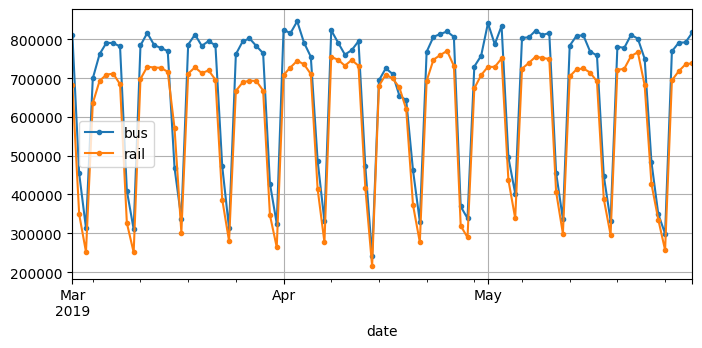

In [ ]:
df[["bus","rail"]]["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8,3.5));

Since there are multiple values per timestep its a _multivariate time series_ dataset. The multiple values being referred here is the bus and rail ride count on any given day.
If we only look at one column say only bus ridership count, it would mean the dataset is _univariate time series_ dataset.

# Naive Forecast

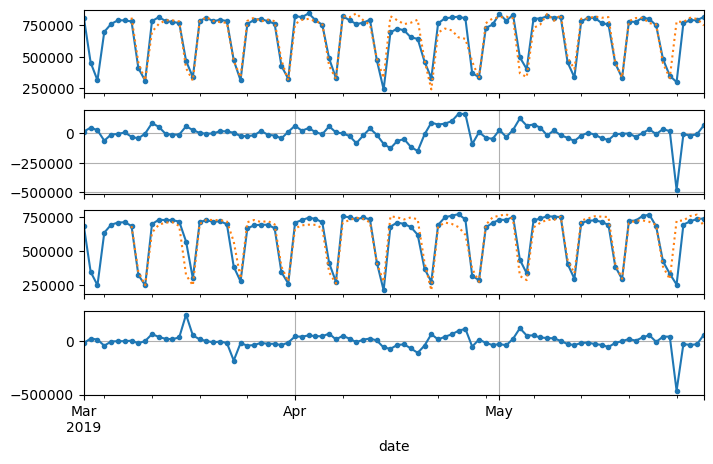

In [ ]:
# Plot the original timeseries overlapped with same timeseries lagged by a week
fig,axs= plt.subplots(4,1, sharex=True,figsize=(8,5))

bus_diff_7= df[["bus"]].diff(7)["2019-03":"2019-05"]
rail_diff_7= df[["rail"]].diff(7)["2019-03":"2019-05"]
df[["bus"]]["2019-03":"2019-05"].plot(ax=axs[0], legend=False, marker=".") # Plot the original timeseries for bus
df[["bus"]]["2019-03":"2019-05"].shift(7).plot(ax=axs[0], legend=False, linestyle=":")
bus_diff_7.plot(ax=axs[1],legend=False, marker=".", grid=True)

df[["rail"]]["2019-03":"2019-05"].plot(ax=axs[2], legend=False, marker=".") # Plot the original timeseries for bus
df[["rail"]]["2019-03":"2019-05"].shift(7).plot(ax=axs[2], legend=False, linestyle=":")
rail_diff_7.plot(ax=axs[3],legend=False, marker=".", grid=True);

In [ ]:
bus_diff_7.abs().mean()

bus    43915.608696
dtype: float64

In [ ]:
rail_diff_7.abs().mean()

rail    42143.271739
dtype: float64

> The MAE, MAPE and MSE are among the most common metrics we can use to evaluate forecasts.

# Prepare the Training
We will use `tf.keras.utils.timeseries_dataset_from_array` to prepare the training set

In [ ]:
rail_train= df[["rail"]]["2016-01":"2018-12"]/1e6
rail_valid= df[["rail"]]["2019-01":"2019-05"]/1e6
rail_test= df[["rail"]]["2019-06":]/1e6
len(rail_train), len(rail_valid), len(rail_test)

(1096, 151, 914)

In [ ]:
seq_length= 21
tf.random.set_seed(42)
train_ds= tf.keras.utils.timeseries_dataset_from_array(data=rail_train.to_numpy()
                                                       ,sequence_length=seq_length
                                                       ,batch_size=32
                                                       ,targets=rail_train[seq_length:]
                                                       ,shuffle=True
                                                       ,seed=42)
val_ds= tf.keras.utils.timeseries_dataset_from_array(data=rail_valid.to_numpy()
                                                       ,sequence_length=seq_length
                                                       ,batch_size=32
                                                       ,targets=rail_valid[seq_length:]
                                                       ,shuffle=True
                                                       ,seed=42)
test_ds= tf.keras.utils.timeseries_dataset_from_array(data=rail_test.to_numpy()
                                                       ,sequence_length=seq_length
                                                       ,batch_size=32
                                                       ,targets=rail_test[seq_length:]
                                                       ,shuffle=True
                                                       ,seed=42)

In [ ]:
for inputs, labels in train_ds.take(1):
  print(f'Inputs shape (batch, timestep, features): {inputs.shape}')
  print(f'Labels shape (batch, timestep, features): {labels.shape}')
  # Let us check the entries of 1 batch
  input_batch_0,label_batch_0= inputs[0],labels[0]
  print(f" [Window] -> [Horizon]")
  print(f"{tf.squeeze(input_batch_0)} -> {tf.squeeze(label_batch_0)}")


Inputs shape (batch, timestep, features): (32, 21, 1)
Labels shape (batch, timestep, features): (32, 1)
 [Window] -> [Horizon]
[0.848003 0.796878 0.481334 0.320608 0.750619 0.769526 0.794572 0.805362
 0.769792 0.422323 0.320982 0.75386  0.758455 0.78067  0.794788 0.755771
 0.393884 0.312232 0.772803 0.785554 0.79687 ] -> 0.800535


In [ ]:
array = range(0,100)
example_ds= tf.keras.utils.timeseries_dataset_from_array(tf.expand_dims(array,axis=1)
                                                         ,targets=tf.expand_dims(array[seq_length:],axis=1)
                                                         ,sequence_length=seq_length
                                                         ,batch_size=8
                                                         )

In [ ]:
for inputs, labels in example_ds.take(1):
  print(f'Inputs shape (batch, timestep, features): {inputs.shape}')
  print(f'Labels shape (batch, timestep, features): {labels.shape}')
  # Let us check the entries of 1 batch
  print(f" [Window] -> [Horizon]")
  for input,label in zip(inputs,labels):

    print(f"{tf.squeeze(input)} -> {tf.squeeze(label)}")


Inputs shape (batch, timestep, features): (8, 21, 1)
Labels shape (batch, timestep, features): (8, 1)
 [Window] -> [Horizon]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] -> 21
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] -> 22
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] -> 23
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] -> 24
[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] -> 25
[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25] -> 26
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26] -> 27
[ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27] -> 28


In [ ]:
example_ds= tf.keras.utils.timeseries_dataset_from_array(tf.expand_dims(array,axis=1)
                                                         ,targets=tf.expand_dims(array[seq_length:],axis=1)
                                                         ,sequence_length=seq_length
                                                         ,batch_size=8
                                                         ,sequence_stride=2
                                                         )
for inputs, labels in example_ds.take(1):
  print(f'Inputs shape (batch, timestep, features): {inputs.shape}')
  print(f'Labels shape (batch, timestep, features): {labels.shape}')
  # Let us check the entries of 1 batch
  print(f" [Window] -> [Horizon]")
  for input,label in zip(inputs,labels):

    print(f"{tf.squeeze(input)} -> {tf.squeeze(label)}")


Inputs shape (batch, timestep, features): (8, 21, 1)
Labels shape (batch, timestep, features): (8, 1)
 [Window] -> [Horizon]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] -> 21
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] -> 23
[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] -> 25
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26] -> 27
[ 8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28] -> 29
[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30] -> 31
[12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32] -> 33
[14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34] -> 35


In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self,label_index=None):
    super().__init__()
    self.label_index= label_index

  def call(self,inputs):
    if self.label_index is None:
      return inputs
    result= inputs[:,:, self.label_index]
    return result[:,:,tf.newaxis]

In [ ]:
column_indices = {name: i for i, name in enumerate(rail_train.columns)}
column_indices

{'rail': 0}

# Baseline Model

In [ ]:
baseline= Baseline(label_index=column_indices["rail"])
baseline.compile(loss=tf.keras.losses.mse
                 ,metrics=["mae"])
val_performance= {}
test_performance= {}
val_performance["Baseline"]= baseline.evaluate(val_ds)
test_performance["Baseline"]= baseline.evaluate(test_ds)

28/28 [==============================] - 0s 7ms/step - loss: 0.0233 - mae: 0.0850


# Linear Model
A `tf.keras.layers.Dense` layer with no activation set is a linear model.

In [ ]:
tf.random.set_seed(42)

linear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
linear_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = linear_model.fit(train_ds, validation_data=val_ds, epochs=50,
                    callbacks=[early_stopping_cb])

Epoch 1/50
34/34 [==============================] - 1s 20ms/step - loss: 0.1002 - mae: 0.3547 - val_loss: 0.0341 - val_mae: 0.2127
Epoch 2/50
34/34 [==============================] - 0s 10ms/step - loss: 0.0152 - mae: 0.1396 - val_loss: 0.0149 - val_mae: 0.1425
Epoch 3/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0112 - mae: 0.1207 - val_loss: 0.0137 - val_mae: 0.1356
Epoch 4/50
34/34 [==============================] - 0s 6ms/step - loss: 0.0103 - mae: 0.1155 - val_loss: 0.0125 - val_mae: 0.1283
Epoch 5/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0094 - mae: 0.1103 - val_loss: 0.0118 - val_mae: 0.1232
Epoch 6/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0085 - mae: 0.1030 - val_loss: 0.0109 - val_mae: 0.1174
Epoch 7/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0078 - mae: 0.0981 - val_loss: 0.0099 - val_mae: 0.1117
Epoch 8/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0071 - mae: 0.

In [ ]:
val_performance["Linear"]= linear_model.evaluate(val_ds)
test_performance["Linear"]= linear_model.evaluate(test_ds)

28/28 [==============================] - 0s 5ms/step - loss: 0.0039 - mae: 0.0734


# Dense Model

In [ ]:
dense_model = tf.keras.Sequential([
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=1)
])


dense_model.compile(loss=tf.keras.losses.Huber()
                     ,optimizer=tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
                     ,metrics=["mae"])
history = dense_model.fit(train_ds, validation_data=val_ds, epochs=50,
                    callbacks=[early_stopping_cb])

val_performance['Dense'] = dense_model.evaluate(val_ds)
test_performance['Dense'] = dense_model.evaluate(test_ds, verbose=0)

Epoch 1/50
34/34 [==============================] - 1s 14ms/step - loss: 0.0462 - mae: 0.2441 - val_loss: 0.0190 - val_mae: 0.1639
Epoch 2/50
34/34 [==============================] - 0s 10ms/step - loss: 0.0172 - mae: 0.1568 - val_loss: 0.0187 - val_mae: 0.1586
Epoch 3/50
34/34 [==============================] - 0s 11ms/step - loss: 0.0169 - mae: 0.1602 - val_loss: 0.0192 - val_mae: 0.1511
Epoch 4/50
34/34 [==============================] - 0s 11ms/step - loss: 0.0168 - mae: 0.1590 - val_loss: 0.0190 - val_mae: 0.1513
Epoch 5/50
34/34 [==============================] - 0s 9ms/step - loss: 0.0167 - mae: 0.1604 - val_loss: 0.0185 - val_mae: 0.1549
Epoch 6/50
34/34 [==============================] - 0s 10ms/step - loss: 0.0166 - mae: 0.1608 - val_loss: 0.0185 - val_mae: 0.1543
Epoch 7/50
34/34 [==============================] - 0s 11ms/step - loss: 0.0168 - mae: 0.1583 - val_loss: 0.0180 - val_mae: 0.1596
Epoch 8/50
34/34 [==============================] - 0s 9ms/step - loss: 0.0166 - mae